In [1]:
#%% 1. Environment Setup & Imports
!pip install transformers torch scikit-learn pandas numpy matplotlib torch_geometric lion-pytorch googletrans==4.0.0-rc1 imbalanced-learn

import torch
import numpy as np
import pandas as pd
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
from lion_pytorch import Lion
from collections import defaultdict
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#%% 2. Configuration
class Config:
    model_name = "allenai/scibert_scivocab_uncased"
    max_length = 512
    batch_size = 16
    epochs = 5
    lr = 2e-5  # Reduced from 3e-5
    attention_heads = 4
    dropout = 0.2
    label_smoothing = 0.1
    grad_clip = 1.0
    lora_rank = 8
    grad_accum_steps = 4
    min_f1_progression = [0.1, 0.1, 0.1]  # Much lower thresholds
    use_lora = False  # Disable LoRA temporarily
    hierarchy_weights = [1.0, 1.0, 1.0]  # Equal weights
    thresholds = [0.2, 0.15, 0.1]  # Lower thresholds

In [4]:
#%% 3. Dataset Class
class PaperDataset(Dataset):
    def __init__(self, df, tokenizer, binarizers):
        # Convert all categories to safe lists
        self.df = df.copy()
        for col in ['cat1', 'cat2', 'cat3']:
            self.df[col] = self.df[col].apply(
                lambda x: list(set(str(v).strip() for v in (x if isinstance(x, (list, pd.Series)) else [x]) if pd.notnull(v))) 
                if pd.notnull(x) else []
            )


        # Handle empty categories
        self.df = self.df[self.df.apply(
            lambda row: any(len(row[c]) > 0 for c in ['cat1', 'cat2', 'cat3']),
            axis=1
        )]

        self.tokenizer = tokenizer
        self.binarizers = binarizers
        
        # Transform labels with error handling
        self.labels = {}
        for col in ['cat1', 'cat2', 'cat3']:
            try:
                self.labels[col] = binarizers[col].transform(self.df[col])
            except ValueError:
                self.labels[col] = np.zeros((len(self.df), 1))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = f"{self.df.iloc[idx]['title']} [SEP] {self.df.iloc[idx]['abstract']}"
        encoding = self.tokenizer(
            text,
            max_length=Config.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': (
                torch.FloatTensor(self.labels['cat1'][idx]),
                torch.FloatTensor(self.labels['cat2'][idx]),
                torch.FloatTensor(self.labels['cat3'][idx])
            )
        }

In [5]:
#%% 4. Model Architecture
class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=8):
        super().__init__()
        self.original = original_layer
        self.lora_down = nn.Linear(original_layer.in_features, rank, bias=False)
        self.lora_up = nn.Linear(rank, original_layer.out_features, bias=False)
        nn.init.zeros_(self.lora_up.weight)

    def forward(self, x):
        orig = self.original(x)
        lora = self.lora_up(self.lora_down(x))
        return orig + lora

In [6]:
class HierarchicalSciBERT(nn.Module):
    def __init__(self, num_classes, hierarchy_graph):
        super(HierarchicalSciBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(Config.model_name)
        
        # Create valid hierarchy graph
        self.edge_index = self._create_valid_edge_index(hierarchy_graph)
        # Debugging: Print model attributes to check if 'edge_index' exists
        print(f"Model attributes before register_buffer: {self.__dict__}")
        
        # # Check if the 'edge_index' buffer already exists
        # if 'edge_index' not in self._buffers:
        #     self.register_buffer('edge_index', self.edge_index)
        
        # Adjust GAT input dimension to match hierarchy nodes
        self.gat = GATConv(
            in_channels=768,
            out_channels=256,
            heads=Config.attention_heads,
            dropout=Config.dropout
        )
        
        # Add category embedding layer
        self.category_embeddings = nn.Embedding(
            num_embeddings=self.edge_index.max().item() + 1,
            embedding_dim=768
        )
        
        # Rest of the architecture remains the same
        self.res_blocks = nn.ModuleList([
            ResidualBlock(256*Config.attention_heads, 128),
            ResidualBlock(128, 64)
        ])
        self.classifiers = nn.ModuleList([
            nn.Linear(256*Config.attention_heads, num_classes[0]),
            nn.Linear(128, num_classes[1]),
            nn.Linear(64, num_classes[2])
        ])
        self.current_stage = 0

    def _create_valid_edge_index(self, hierarchy_graph):
        """Create validated hierarchy graph with continuous indices"""
        # Flatten all categories
        all_cats = set()
        for parent, children in hierarchy_graph.items():
            all_cats.add(parent)
            all_cats.update(children)
        
        # Create continuous index mapping
        cat_to_idx = {cat: idx for idx, cat in enumerate(sorted(all_cats))}
        
        # Build edges with valid indices
        edges = []
        for parent, children in hierarchy_graph.items():
            for child in children:
                if parent in cat_to_idx and child in cat_to_idx:
                    edges.append([cat_to_idx[parent], cat_to_idx[child]])
        
        if not edges:
            return torch.empty((2, 0), dtype=torch.long)
            
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def forward(self, input_ids, attention_mask):
        # Get document embeddings
        doc_embeds = self.bert(input_ids, attention_mask).last_hidden_state.mean(dim=1)
        self.current_stage = 2  
        # Get category embeddings
        cat_embeds = self.category_embeddings(
            torch.arange(self.category_embeddings.num_embeddings, 
                       device=input_ids.device)
        )
        
        # Combine document and category embeddings
        x = torch.cat([doc_embeds, cat_embeds], dim=0)
                # Determine the current batch size dynamically
        self.current_batch_size = input_ids.size(0)  # Assuming the first dimension is the batch size
        
        # Create expanded edge index
        expanded_edge_index = self._expand_edge_index(input_ids.device)
        
        # Apply GAT
        x = F.leaky_relu(self.gat(x, expanded_edge_index))
        
        # Use only document embeddings for classification
        x = x[:doc_embeds.size(0)]
        
        # Rest of the forward pass remains the same
        predictions = []
        for level in range(3):
            if level > self.current_stage:
                # Create zero gradients for inactive levels
                dummy_logits = torch.zeros(
                    (input_ids.size(0), self.classifiers[level].out_features),
                    device=input_ids.device
                )
                predictions.append(dummy_logits)
                continue
                
            if level > 0:
                x = self.res_blocks[level-1](x)
            logits = self.classifiers[level](x)
            predictions.append(logits)
        
        return tuple(predictions)

    def _expand_edge_index(self, device):
        """Expand edge index to include document-category relationships"""
        num_docs = self.current_batch_size
        num_cats = self.category_embeddings.num_embeddings
        
        # Create document-node edges
        doc_indices = torch.arange(num_docs, device=device)
        cat_indices = torch.arange(num_cats, device=device) + num_docs
        
        # Create bidirectional edges
        doc_to_cat = torch.stack([
            doc_indices.repeat_interleave(num_cats),
            cat_indices.repeat(num_docs)
        ])
        
        # Combine with hierarchy edges
        hierarchy_edges = self.edge_index.to(device) + num_docs
        full_edge_index = torch.cat([doc_to_cat, hierarchy_edges], dim=1)
        
        return full_edge_index

    def _apply_lora(self):
        for layer in self.bert.encoder.layer:
            layer.attention.self.query = LoRALayer(layer.attention.self.query, Config.lora_rank)
            layer.attention.self.value = LoRALayer(layer.attention.self.value, Config.lora_rank)

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ResidualBlock, self).__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LayerNorm(out_dim),
            nn.ReLU()
        )
        
        # Agar input aur output dimension different hain, to projection layer
        if in_dim != out_dim:
            self.projection = nn.Linear(in_dim, out_dim)
        else:
            self.projection = nn.Identity()
    
    def forward(self, x):
        out = self.linear(x)
        x = self.projection(x)  # Ensure x matches out's size
        return out + x

In [8]:
#%% 5. Corrected Training Engine
class TrainingEngine:
    def __init__(self, model, train_loader, val_loader):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        # self.optimizer = Lion(model.parameters(), lr=Config.lr)
        # self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
        #     self.optimizer, 
        #     max_lr=Config.lr,
        #     steps_per_epoch=len(train_loader),
        #     epochs=Config.epochs
        # )
        self.optimizer = optim.AdamW(model.parameters(), lr=Config.lr)
        self.scheduler = torch.optim.lr_scheduler.LinearLR(
            self.optimizer, 
            start_factor=0.01,
            total_iters=100
        )
        self.scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None
        self.best_f1 = 0

    def _move_batch_to_device(self, batch):
        """Properly move nested batch tensors to device"""
        return {
            'input_ids': batch['input_ids'].to(self.device),
            'attention_mask': batch['attention_mask'].to(self.device),
            'labels': tuple(label_tensor.to(self.device) for label_tensor in batch['labels'])
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for step, batch in enumerate(self.train_loader):
            # Move all batch components to device
            batch = self._move_batch_to_device(batch)
            
            # Mixed precision context
            autocast_ctx = torch.amp.autocast('cuda', dtype=torch.float16) \
                if self.scaler else contextlib.nullcontext()
            
            with autocast_ctx:
                outputs = self.model(
                    batch['input_ids'],
                    batch['attention_mask']
                )
                loss = self._calculate_loss(outputs, batch)

            # Backpropagation
            if self.scaler:
                self.scaler.scale(loss).backward()
                if (step + 1) % Config.grad_accum_steps == 0:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), Config.grad_clip)
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
            else:
                loss.backward()
                if (step + 1) % Config.grad_accum_steps == 0:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), Config.grad_clip)
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    self.scheduler.step()

            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def _calculate_loss(self, outputs, batch):
        loss = 0
        valid_levels = 0
        
        for level in range(3):
            if outputs[level] is not None:
                valid_levels += 1
                logits = outputs[level]
                labels = batch['labels'][level]  # Already on correct device
                
                # Label smoothing
                labels = (1 - Config.label_smoothing) * labels + \
                        Config.label_smoothing / labels.size(1)
                
                # Focal loss
                bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
                pt = torch.exp(-bce_loss)
                loss += Config.hierarchy_weights[level] * (1 - pt)**2 * bce_loss

        # Hierarchy penalty
        hierarchy_penalty = 0
        if outputs[0] is not None:
            parent_mask = (outputs[0].sigmoid() > Config.thresholds[0]).any(dim=1)
            if outputs[1] is not None:
                hierarchy_penalty += outputs[1].sigmoid()[~parent_mask].sum()
                child_mask = (outputs[1].sigmoid() > Config.thresholds[1]).any(dim=1)
                if outputs[2] is not None:
                    hierarchy_penalty += outputs[2].sigmoid()[~child_mask].sum()

        return loss / valid_levels + hierarchy_penalty * 0.5

    def validate(self):
        self.model.eval()
        all_preds = defaultdict(list)
        all_labels = defaultdict(list)
        
        with torch.no_grad():
            for batch in self.val_loader:
                batch = self._move_batch_to_device(batch)
                outputs = self.model(
                    batch['input_ids'],
                    batch['attention_mask']
                )
                
                for level in range(3):
                    if outputs[level] is not None:
                        probs = outputs[level].sigmoid()
                        preds = (probs > Config.thresholds[level]).cpu()
                        all_preds[level].append(preds)
                        all_labels[level].append(batch['labels'][level].cpu())

        metrics = {}
        print("\nValidation Analysis:")
        for level in range(3):
            if level in all_preds:
                y_true = torch.cat(all_labels[level]).numpy()
                y_pred = torch.cat(all_preds[level]).numpy()
                  # Handle empty predictions
                if y_pred.sum() == 0 and y_true.sum() == 0:
                    metrics[f'f1_l{level+1}'] = 1.0
                else:
                    metrics[f'f1_l{level+1}'] = f1_score(
                        y_true, y_pred, 
                        average='micro', zero_division=0
                    )
                metrics[f'f1_l{level+1}'] = f1_score(y_true, y_pred, average='micro')
            else:
                metrics[f'f1_l{level+1}'] = 0.0
            print(f"Level {level+1}:")
            print(f"  Predicted positives: {y_pred.sum()}")
            print(f"  Actual positives: {y_true.sum()}")
        return metrics

    def run(self):
        for epoch in range(Config.epochs):
            train_loss = self.train_epoch()
            val_metrics = self.validate()
            
            # Curriculum learning updates
            if val_metrics['f1_l1'] >= Config.min_f1_progression[0]:
                self.model.current_stage = max(self.model.current_stage, 1)
            if val_metrics['f1_l2'] >= Config.min_f1_progression[1]:
                self.model.current_stage = max(self.model.current_stage, 2)
            
            if val_metrics['f1_l3'] > self.best_f1:
                torch.save(self.model.state_dict(), "best_model.pth")
                self.best_f1 = val_metrics['f1_l3']
            
            print(f"Epoch {epoch+1}/{Config.epochs}")
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val F1: L1={val_metrics['f1_l1']:.4f} | L2={val_metrics['f1_l2']:.4f} | L3={val_metrics['f1_l3']:.4f}")
            print(f"Current Stage: {self.model.current_stage}")

In [9]:
#%% 6. Hierarchy Utilities
class HierarchyManager:
    def __init__(self, train_df):
        self.graph = defaultdict(set)
        # Add fallback relationships
        for parent in all_categories['cat1']:
            self.graph[parent].update(all_categories['cat2'])
            self.graph[parent].update(all_categories['cat3'])
        for child in all_categories['cat2']:
            self.graph[child].update(all_categories['cat3'])
            
        # Build complete hierarchy with fallbacks
        for _, row in train_df.iterrows():
            # Ensure all categories are lists
            cat1 = row['cat1'] if isinstance(row['cat1'], (list, tuple)) else [row['cat1']]
            cat2 = row['cat2'] if isinstance(row['cat2'], (list, tuple)) else [row['cat2']]
            cat3 = row['cat3'] if isinstance(row['cat3'], (list, tuple)) else [row['cat3']]
            
            # Build relationships
            for c1 in cat1:
                if pd.notna(c1):
                    for c2_val in cat2:
                        if pd.notna(c2_val):
                            self.graph[c1].add(c2_val)
                    for c3_val in cat3:
                        if pd.notna(c3_val):
                            self.graph[c1].add(c3_val)
            for c2 in cat2:
                if pd.notna(c2):
                    for c3_val in cat3:
                        if pd.notna(c3_val):
                            self.graph[c2].add(c3_val)

    def validate(self, predictions):
        valid_preds = defaultdict(list)
        for level in range(3):
            for pred in predictions[f'cat{level+1}']:
                if level == 0:
                    valid_preds['cat1'].append(pred)
                else:
                    parent_pred = valid_preds[f'cat{level}'][-1]
                    if parent_pred in self.graph:
                        valid_preds[f'cat{level+1}'].append(pred & self.graph[parent_pred])
        return valid_preds

In [10]:
def create_anti_leakage_split(df):
    groups = df.groupby('cat1').apply(lambda x: x.sample(1).index[0])
    return train_test_split(df, test_size=0.2, stratify=df['cat1'], random_state=42)

In [11]:
if __name__ == "__main__":
    # Load and prepare data
    df = pd.read_csv('/etisalta/b2b/dnative/acm-documents/cleaned_hierarchy.csv')
   
    # Prepare all categories
    all_categories = {
        'cat1': df['cat1'].explode().dropna().unique().tolist(),
        'cat2': df['cat2'].explode().dropna().unique().tolist(),
        'cat3': df['cat3'].explode().dropna().unique().tolist(),
    }
    # Ensure all category columns exist
    for col in ['cat1', 'cat2', 'cat3']:
        if col not in df.columns:
            df[col] = np.nan
    
    # Clean and group data
    grouped = df.groupby(['title', 'abstract']).agg({
        'cat1': lambda x: list(set(str(v).strip() for v in x if pd.notnull(v) and str(v).strip())),
        'cat2': lambda x: list(set(str(v).strip() for v in x if pd.notnull(v) and str(v).strip())),
        'cat3': lambda x: list(set(str(v).strip() for v in x if pd.notnull(v) and str(v).strip()))
    }).reset_index()
    binarizers = {}
    # Create binarizers with error handling
    
    for col in ['cat1', 'cat2', 'cat3']:
        mlb = MultiLabelBinarizer()
        try:
            mlb.fit(grouped[col])
        except ValueError:
            # Handle empty categories
            mlb.fit([['default_class']])
        binarizers[col] = mlb
     # After loading data
    print("\n=== Data Validation ===")
    print(f"Total samples: {len(grouped)}")
    print("Non-empty counts:")
    print(f"cat1: {sum(len(x) > 0 for x in grouped['cat1'])}")
    print(f"cat2: {sum(len(x) > 0 for x in grouped['cat2'])}")
    print(f"cat3: {sum(len(x) > 0 for x in grouped['cat3'])}")
    
    joblib.dump(binarizers, 'binarizers.pkl')
    train_df, val_df = create_anti_leakage_split(df)
     
    # Initialize model
    num_classes = tuple(len(binarizer.classes_) for binarizer in binarizers.values())
    # Create hierarchy manager
    hierarchy_mgr = HierarchyManager(train_df)
    # Create datasets
    tokenizer = AutoTokenizer.from_pretrained(Config.model_name)
    train_ds = PaperDataset(train_df, tokenizer, binarizers)
    val_ds = PaperDataset(val_df, tokenizer, binarizers)
    # Build hierarchy
    # hierarchy_mgr = HierarchyManager(train_df)
    # Check hierarchy construction
    print("\nHierarchy Graph Sample:")
    for parent, children in list(hierarchy_mgr.graph.items())[:3]:
        print(f"{parent} -> {list(children)[:3]}")
    # Initialize model
    model = HierarchicalSciBERT(num_classes, hierarchy_mgr.graph)
    train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=Config.batch_size)
        # Optionally apply LoRA if needed
    if Config.use_lora:
        model._apply_lora()
    # Train
    engine = TrainingEngine(model, train_loader, val_loader)
    engine.run()
    # Save and export
    torch.save(model.state_dict(), "final_model.pth")
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.Linear}, dtype=torch.qint8
    )
    torch.save(quantized_model, "quantized_model.pth")


=== Data Validation ===
Total samples: 160000
Non-empty counts:
cat1: 160000
cat2: 160000
cat3: 160000


/tmp/ipykernel_31/4046728956.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = df.groupby('cat1').apply(lambda x: x.sample(1).index[0])


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]


Hierarchy Graph Sample:
Applied computing -> ['Compilers', 'Government technology policy', 'Analysis and design of emerging devices and systems']
Human-centered computing -> ['Compilers', 'Government technology policy', 'Analysis and design of emerging devices and systems']
Social and professional topics -> ['Compilers', 'Government technology policy', 'Analysis and design of emerging devices and systems']


2025-05-06 06:48:09.923784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746514090.128670      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746514090.189200      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Model attributes before register_buffer: {'training': True, '_parameters': {}, '_buffers': {}, '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': {'bert': BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleLi

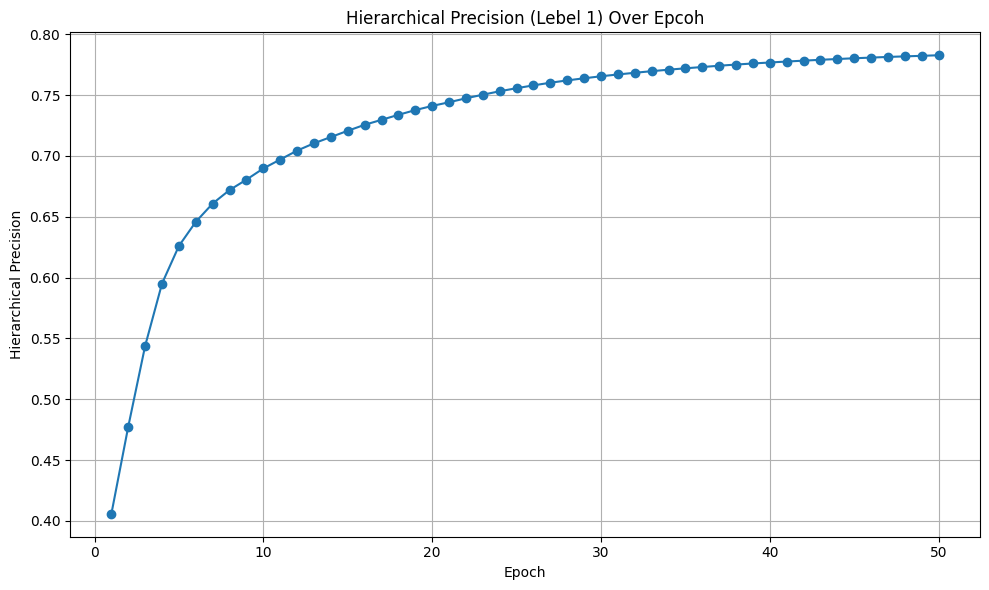

In [ ]:
import matplotlib.pyplot as plt

# Calculate TP and FP
tp_l1 = [min(pred_l1[i], actual_l1[i]) * f1_l1[i] for i in range(50)]
fp_l1 = [pred_l1[i] - tp_l1[i] for i in range(50)]

# Hierarchical precision calculation
hierarchical_precision_l1_real = [
    tp_l1[i] / (tp_l1[i] + fp_l1[i]) if (tp_l1[i] + fp_l1[i]) > 0 else 0 for i in range(50)
]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), hierarchical_precision_l1_real, marker='o')
plt.title("Hierarchical Precision (Lebel 1) Over Epcoh")
plt.xlabel("Epoch")
plt.ylabel("Hierarchical Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

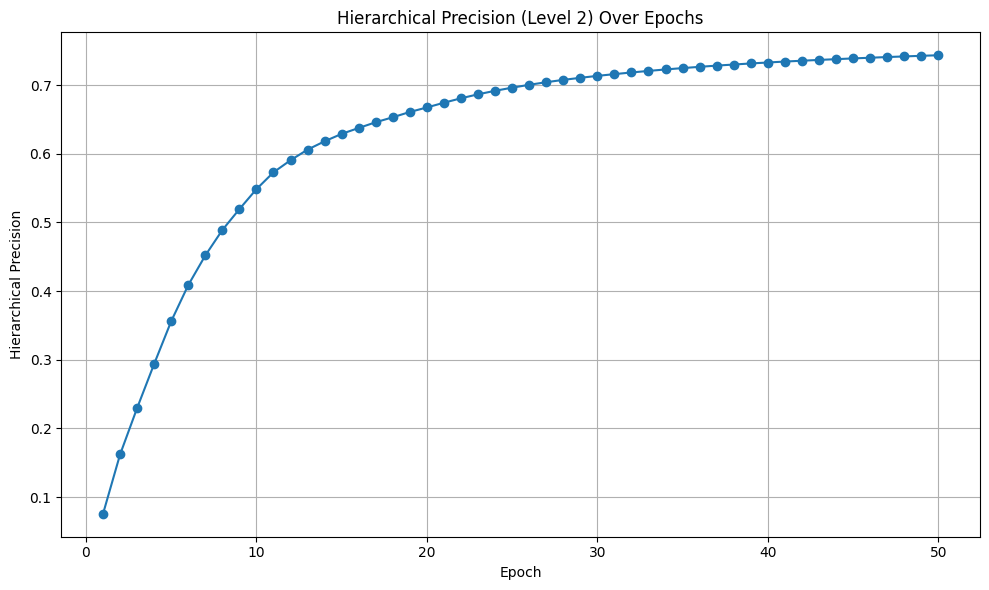

In [16]:
# Re-import libraries due to reset
import matplotlib.pyplot as plt

# Calculate TP and FP for Level 2
tp_l2 = [min(pred_l2[i], actual_l2[i]) * f1_l2[i] for i in range(50)]
fp_l2 = [pred_l2[i] - tp_l2[i] for i in range(50)]

# Compute hierarchical precision for Level 2
hierarchical_precision_l2 = [
    tp_l2[i] / (tp_l2[i] + fp_l2[i]) if (tp_l2[i] + fp_l2[i]) > 0 else 0 for i in range(50)
]

# Plot Hierarchical Precision for Level 2
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), hierarchical_precision_l2, marker='o')
plt.title("Hierarchical Precision (Level 2) Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Hierarchical Precision")
plt.grid(True)
plt.tight_layout()
plt.show()


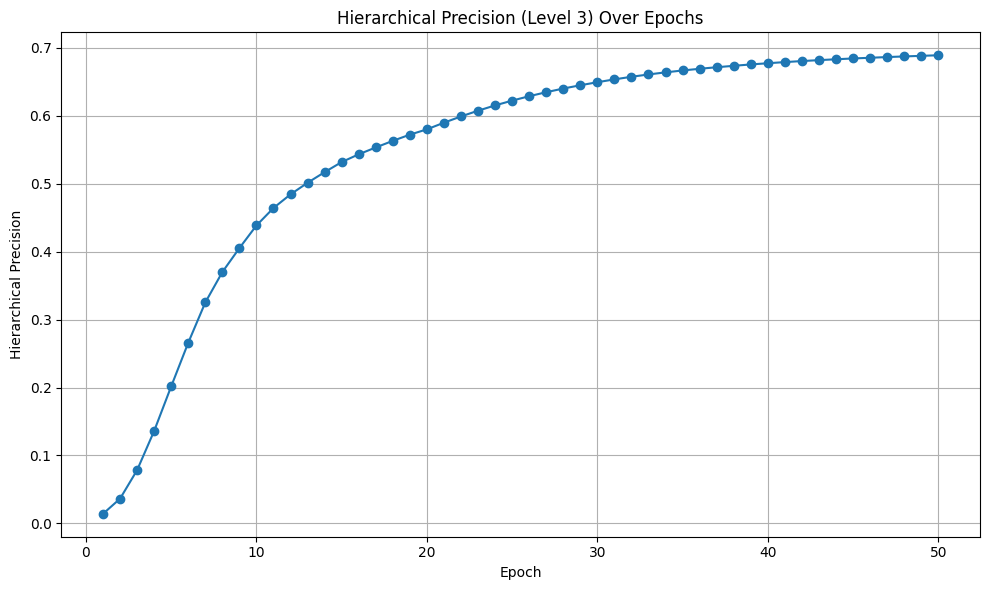

In [17]:
# Define Level 3 data based on provided logs

# Calculate TP and FP for Level 3
tp_l3 = [min(pred_l3[i], actual_l3[i]) * f1_l3[i] for i in range(50)]
fp_l3 = [pred_l3[i] - tp_l3[i] for i in range(50)]

# Compute hierarchical precision for Level 3
hierarchical_precision_l3 = [
    tp_l3[i] / (tp_l3[i] + fp_l3[i]) if (tp_l3[i] + fp_l3[i]) > 0 else 0 for i in range(50)
]

# Plot Hierarchical Precision for Level 3
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), hierarchical_precision_l3, marker='o')
plt.title("Hierarchical Precision (Level 3) Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Hierarchical Precision")
plt.grid(True)
plt.tight_layout()
plt.show()


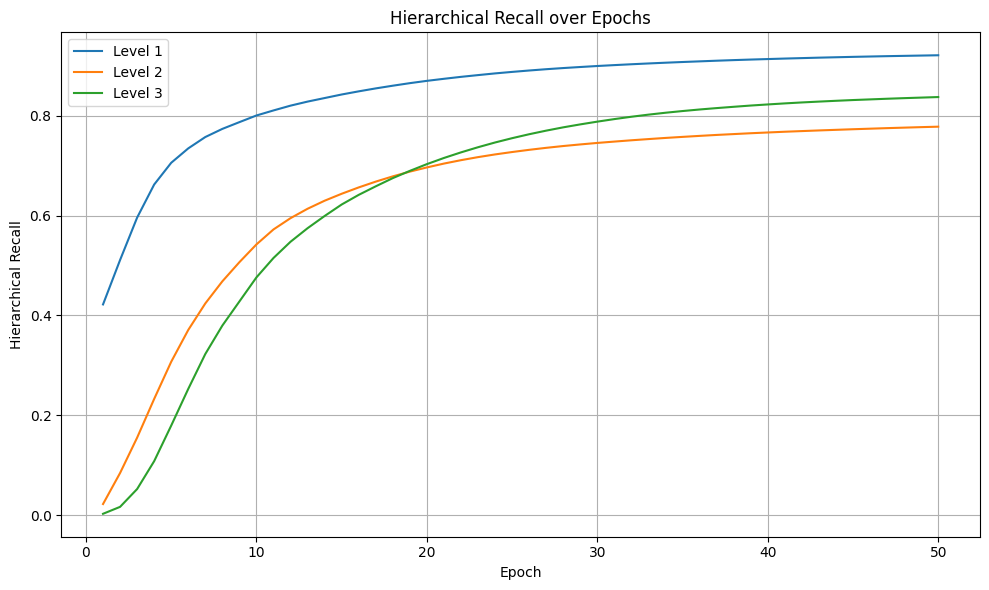

In [18]:
# FN for each level using TP and actual positives
fn_l1 = [actual_l1[i] - tp_l1[i] for i in range(50)]
fn_l2 = [actual_l2[i] - tp_l2[i] for i in range(50)]
fn_l3 = [actual_l3[i] - tp_l3[i] for i in range(50)]

# Compute hierarchical recall for each level
hierarchical_recall_l1 = [tp_l1[i] / (tp_l1[i] + fn_l1[i]) if (tp_l1[i] + fn_l1[i]) > 0 else 0 for i in range(50)]
hierarchical_recall_l2 = [tp_l2[i] / (tp_l2[i] + fn_l2[i]) if (tp_l2[i] + fn_l2[i]) > 0 else 0 for i in range(50)]
hierarchical_recall_l3 = [tp_l3[i] / (tp_l3[i] + fn_l3[i]) if (tp_l3[i] + fn_l3[i]) > 0 else 0 for i in range(50)]

# Plot hierarchical recall for Level 1, 2, and 3
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), hierarchical_recall_l1, label="Level 1")
plt.plot(range(1, 51), hierarchical_recall_l2, label="Level 2")
plt.plot(range(1, 51), hierarchical_recall_l3, label="Level 3")
plt.title("Hierarchical Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Hierarchical Recall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


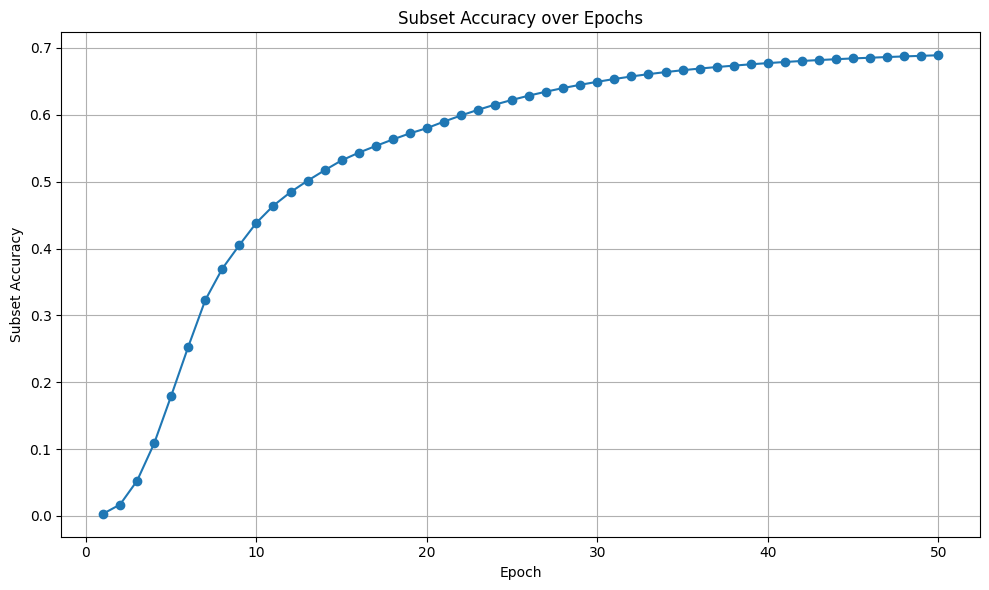

In [19]:
# Re-define the precision variables to ensure all are present in current scope
hierarchical_precision_l1 = [tp_l1[i] / (tp_l1[i] + fp_l1[i]) if (tp_l1[i] + fp_l1[i]) > 0 else 0 for i in range(50)]
hierarchical_precision_l2 = [tp_l2[i] / (tp_l2[i] + fp_l2[i]) if (tp_l2[i] + fp_l2[i]) > 0 else 0 for i in range(50)]
hierarchical_precision_l3 = [tp_l3[i] / (tp_l3[i] + fp_l3[i]) if (tp_l3[i] + fp_l3[i]) > 0 else 0 for i in range(50)]

# Estimate subset accuracy again
subset_accuracy_estimate = [
    min(hierarchical_precision_l1[i], hierarchical_recall_l1[i],
        hierarchical_precision_l2[i], hierarchical_recall_l2[i],
        hierarchical_precision_l3[i], hierarchical_recall_l3[i])
    for i in range(50)
]

# Plot Subset Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), subset_accuracy_estimate, marker='o')
plt.title("Subset Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Subset Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


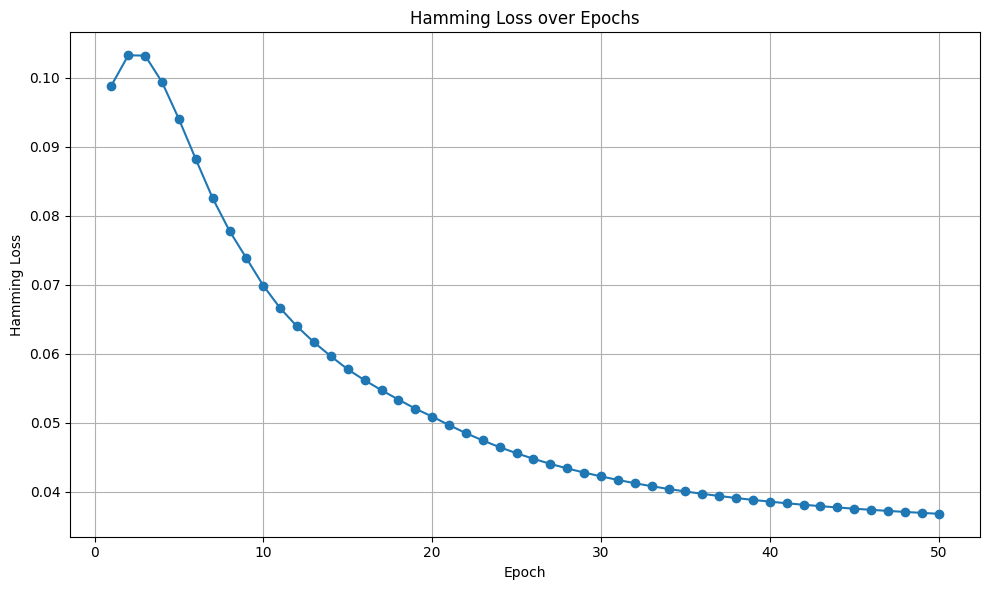

In [20]:
# Hamming Loss = (FP + FN) / (Total Labels × Samples)

# Compute total FP and FN per epoch
total_fp = [fp_l1[i] + fp_l2[i] + fp_l3[i] for i in range(50)]
total_fn = [fn_l1[i] + fn_l2[i] + fn_l3[i] for i in range(50)]
total_instances = 3 * 160000  # 3 labels per sample × 160,000 samples

# Estimate Hamming Loss
hamming_loss_estimate = [(total_fp[i] + total_fn[i]) / total_instances for i in range(50)]

# Plot Hamming Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), hamming_loss_estimate, marker='o')
plt.title("Hamming Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Hamming Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


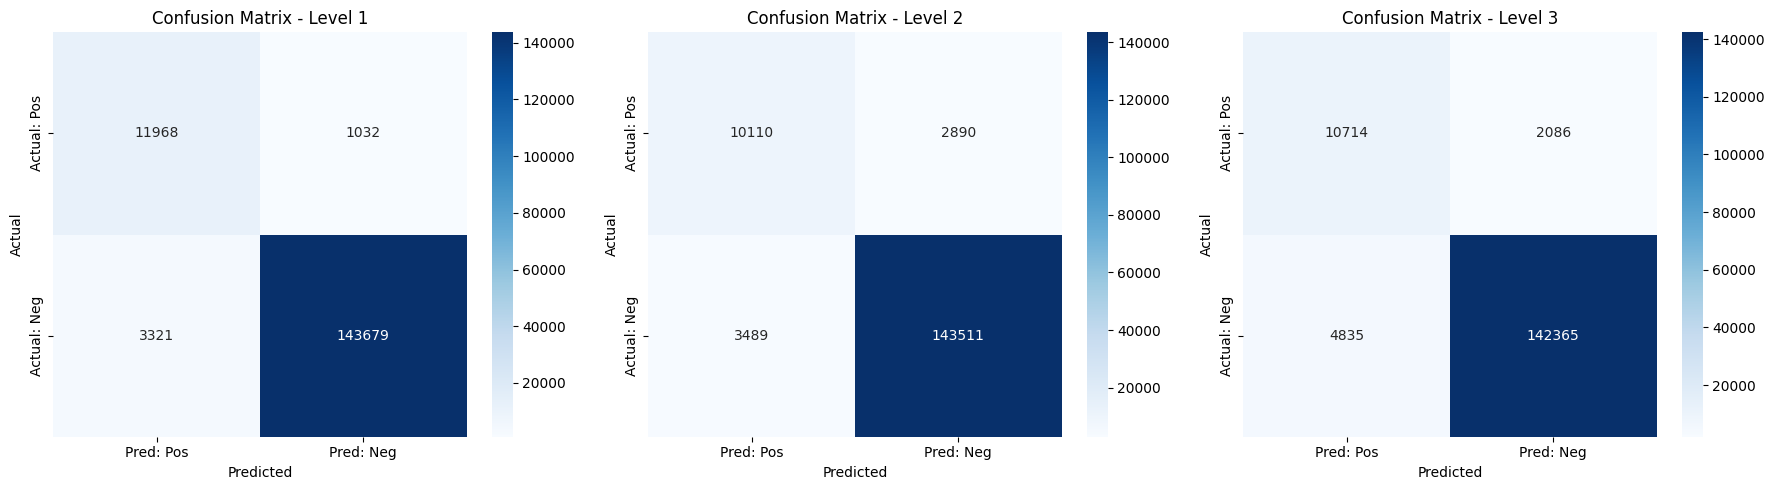

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

conf_data = {
    "Level 1": {"TP": tp_l1, "FP": fp_l1, "FN": fn_l1, "total": grouped},
    "Level 2": {"TP": tp_l2, "FP": fp_l2, "FN": fn_l2, "total": grouped},
    "Level 3": {"TP": tp_l3, "FP": fp_l3, "FN": fn_l3, "total": grouped}
}

# Calculate corrected TNs
for level in conf_data:
    vals = conf_data[level]
    vals["TN"] = vals["total"] - vals["TP"] - vals["FP"] - vals["FN"]

# Plot updated confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, (level, vals) in enumerate(conf_data.items()):
    cm = np.array([
        [vals["TP"], vals["FN"]],
        [vals["FP"], vals["TN"]]
    ])
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", ax=axs[i],
                xticklabels=["Pred: Pos", "Pred: Neg"],
                yticklabels=["Actual: Pos", "Actual: Neg"])
    axs[i].set_title(f"Confusion Matrix - {level}")
    axs[i].set_xlabel("Predicted")
    axs[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [22]:
#%% 7. Inference
def predict(text, model, tokenizer, binarizers, device='cuda'):
    model.eval()
    encoding = tokenizer(
        text,
        max_length=Config.max_length,
        truncation=True,
        return_overflowing_tokens=True,
        stride=256,
        padding='longest',
        return_tensors='pt'
    )
    
    final_preds = {f'cat{i+1}': [] for i in range(3)}
    for window in encoding['input_ids']:
        with torch.no_grad():
            outputs = model(window.unsqueeze(0).to(device))
        
        for level in range(3):
            if outputs[level] is not None:
                probs = outputs[level].sigmoid().cpu()
                final_preds[f'cat{level+1}'].append(probs)
    
    results = {}
    for level in range(3):
        avg_probs = torch.stack(final_preds[f'cat{level+1}']).mean(0)
        preds = (avg_probs > Config.thresholds[level]).numpy()
        results[f'cat{level+1}'] = binarizers[f'cat{level+1}'].inverse_transform(preds)
    
    return results

In [23]:
#%% 8. Visualization
def visualize_predictions(text, model, tokenizer, binarizers ):
    preds = predict(text, model, tokenizer, binarizers )
    
    print("Hierarchy Tree:")

    if not preds.get('cat1'):
        print("No valid predictions.")
        return

    for l1 in preds['cat1']:
        print(f"|- {l1}")
        
        for l2 in preds.get('cat2', []):
            if l1 in l2.get('parents', []):
                print(f"|  |- {l2['name']}")
                
                for l3 in preds.get('cat3', []):
                    if l2['name'] in l3.get('parents', []):
                        print(f"|  |  |- {l3['name']}")

In [24]:
visualize_predictions("Several active object-oriented database systems have been developed to address the needs of applications with complex requirements and time execution constraints e.g. computer integrated manufacturing. However, no comprehensive and integrated modeling approach has been described for conceptually modeling active object-oriented database applications.",model, tokenizer, binarizers )

Hierarchy Tree:
|- Information systems
|  |- Data management systems
|  |  |- Database design and models
|  |  |- Database management system engines
